In [1]:
import numpy as np
import math
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('fisherman.jpg') #load image
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


Bad key text.latex.preview in file C:\Users\shane\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\shane\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\shane\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

### Calculating Edge Orientation for Fisherman

In [2]:
D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
der_x = cv.filter2D(img_gray, cv.CV_32F, D_x)

In [3]:
D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
der_y = cv.filter2D(img_gray, cv.CV_32F, D_y)

In [4]:
height, width = img_gray.shape
ori_img_gray = np.zeros((height, width), np.float32) #gradient orientation of img_gray

In [5]:
for i in range(0, height):
    for j in range(0, width):
        if der_x[i,j] == 0:
            if der_y[i,j] == 0:
                x = math.inf
                ori_img_gray[i, j] = x
            else:
                y = math.atan2(der_y[i, j], der_x[i, j]) 
                y1 = ((y * 180)/math.pi)
                ori_img_gray[i, j] = y1+90
                if ori_img_gray[i, j] <0:
                    ori_img_gray[i, j] = ori_img_gray[i, j]+360
        else:
            y = math.atan2(der_y[i, j], der_x[i, j]) 
            y1 = ((y * 180)/math.pi)
            ori_img_gray[i, j] = y1+90
            if ori_img_gray[i, j] <0:
                ori_img_gray[i, j] = ori_img_gray[i, j]+360

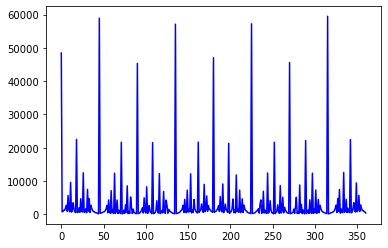

In [6]:
fisher = cv.calcHist([ori_img_gray],[0],None,[361],(0,360))
plt.plot(fisher, color='b')
plt.show()

### Calculating Edge Orientation for Empire

In [7]:
img1 = cv.imread('empire.jpg') #load image
img_gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

In [8]:
D_x1 = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
der_x1 = cv.filter2D(img_gray1, cv.CV_32F, D_x1)

In [9]:
D_y1 = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
der_y1 = cv.filter2D(img_gray1, cv.CV_32F, D_y1)

In [10]:
height1, width1 = img_gray1.shape
ori_img_gray1 = np.zeros((height1, width1), np.float32) #gradient orientation of img_gray

In [11]:
for i in range(0, height1):
    for j in range(0, width1):
        if der_x1[i,j] == 0:
            if der_y1[i,j] == 0:
                x = math.inf
                ori_img_gray1[i, j] = x
            else:
                y = math.atan2(der_y1[i, j], der_x1[i, j]) 
                y1 = ((y * 180)/math.pi)
                ori_img_gray1[i, j] = y1 + 90
                if ori_img_gray1[i, j] <0:
                    ori_img_gray1[i, j] = ori_img_gray1[i, j]+360
        else:
            y = math.atan2(der_y1[i, j], der_x1[i, j]) 
            y1 = ((y * 180)/math.pi)
            ori_img_gray1[i, j] = y1 + 90
            if ori_img_gray1[i, j] <0:
                ori_img_gray1[i, j] = ori_img_gray1[i, j]+360

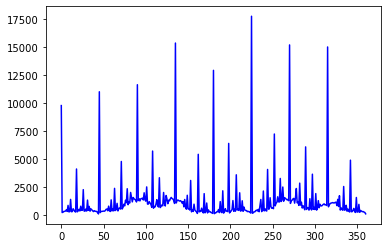

In [12]:
emp = cv.calcHist([ori_img_gray1],[0],None,[361],(0,360))
plt.plot(emp, color='b')
plt.show()

### Applying morphology for document skew estimation

In [13]:
doc = cv.imread('doc.jpg', 0) #Note that the second parameter of imread is set to 0

In [14]:
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
cv.imwrite('doc_bin.png', doc_bin)

True

### Morphological transforms for document skew estimation

In [15]:
closing_se = np.ones((1, 15), np.int) #structuring element for closing

In [16]:
doc_bin = 255 - doc_bin #convert black/white to white/black

In [17]:
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
cv.imwrite('closing.png', closing)

True

In [18]:
opening_se = np.ones((8, 8), np.int) #structuring element for opening

In [19]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
cv.imwrite('opening.png',opening)

True

In [20]:
# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)

In [21]:
def ExtractConnectedComponents(num_labels, labels_im):
    connected_components = [[] for i in range(0, num_labels)]
    height, width = labels_im.shape
    for i in range(0, height):
        for j in range(0, width):
            if labels_im[i, j] >= 0:
                connected_components[labels_im[i, j]].append((j, i))
    return connected_components

In [22]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)

In [23]:
import math
def FindOrientation(cc):
    mx = 0
    my = 0
    mxx = 0
    myy = 0
    mxy = 0
 
    for i in range(0, len(cc)):
        mx += cc[i][0] # cc[i][0] is used to store the x coordinate of pixel cc[i]
        my += cc[i][1] # cc[i][1] is used to store the y coordinate of pixel cc[i]
    mx /= len(cc)
    my /= len(cc)
 
    for i in range(0, len(cc)):
        dx = cc[i][0] - mx
        dy = cc[i][1] - my
        mxx += (dx * dx)
        myy += (dy * dy)
        mxy += (dx * dy)
    mxx /= len(cc)
    myy /= len(cc)
    mxy /= len(cc)
 
    theta = - math.atan2(2 * mxy, mxx - myy) / 2
    return theta

In [24]:
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
 orientations[i] = FindOrientation(connected_components[i])

In [25]:
import statistics
orientation = statistics.median(orientations)

In [26]:
# rotate image
height, width = doc.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate
M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
doc_deskewed = cv.warpAffine(doc, M, (width, height))
cv.imwrite('doc_deskewed.png', doc_deskewed)

True

### doc1 deskew

In [27]:
doc1 = cv.imread('doc_1.jpg', 0) #Note that the second parameter of imread is set to 0

In [28]:
threshold = 200
ret1, doc1_bin = cv.threshold(doc1, threshold, 255, cv.THRESH_BINARY)

In [29]:
doc1_bin = 255 - doc1_bin #convert black/white to white/black

In [31]:
closing1 = cv.morphologyEx(doc1_bin, cv.MORPH_CLOSE, closing_se)

In [33]:
opening1 = cv.morphologyEx(closing1, cv.MORPH_OPEN, opening_se)

In [34]:
num1_labels, labels1_im = cv.connectedComponents(opening1)

In [35]:
connected1_components = ExtractConnectedComponents(num1_labels, labels1_im)

In [36]:
orientations1 = np.zeros(num1_labels, np.float32)
for i in range(0, num1_labels):
    orientations1[i] = FindOrientation(connected1_components[i])

In [37]:
orientation1 = statistics.median(orientations1)

In [38]:
# rotate image
height, width = doc1.shape
c_x1 = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y1 = (height - 1) / 2.0 # row index varies in [0, height-1]
c1 = (c_x1, c_y1) # A point is defined by x and y coordinate
M1 = cv.getRotationMatrix2D(c1, -orientation * 180 / math.pi, 1)
doc1_deskewed = cv.warpAffine(doc1, M1, (width, height))
cv.imwrite('doc1_deskewed.png',doc1_deskewed)

True